# Does a 5 layer neural network on the data in cleaned_spotify.csv

In [ ]:
%pip install pandas numpy lightning scikit-learn torchmetrics matplotlib optuna

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-11.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 48.5 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 54.0 MB/s eta 0:00:00
Using cached kiwisolver-1.4.7-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
Using cached pillow-11.0.0-cp312-cp312-manylinux_2_28_x86_64.whl (4.4 MB)
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
# imports
import os
os.environ['PJRT_DEVICE'] = "GPU"
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from typing import cast, List
from sklearn.decomposition import PCA
import torch._dynamo
torch._dynamo.config.suppress_errors = True
import torchmetrics as tm
import optuna
import plotly
import plotly.express as px

In [4]:
# Load the cleaned data
data = pd.read_csv('csv_outputs/cleaned_spotify.csv')

# Split the data into training and testing sets
prediction = 'track_genre'
categorical_columns = ['track_name', 'artists', 'album_name', 'track_name']
X = data.drop(columns=[prediction, 'track_id', *categorical_columns])
y = data[prediction]

# one hot encode the y values
y = pd.get_dummies(y)

# Normalize and PCA transform the data
X = (X - X.mean()) / X.std()

In [44]:
# split into train and test
X_split, X_test, y_split, y_test = cast(
    List[pd.DataFrame],
    train_test_split(X, y, test_size=0.2, random_state=42)
)

X_train, X_val, y_train, y_val = cast(
    List[pd.DataFrame],train_test_split(
        X_split, y_split,
        test_size=0.25,
        random_state=42
    )
)

# PCA transform the data
n_components = 10
pca_columns = [f'pca_{i}' for i in range(n_components)]
pca = PCA(n_components=n_components)
X_train = pd.DataFrame(
    data=pca.fit_transform(X_train),
    columns=pca_columns
)
X_test = pd.DataFrame(
    data=pca.transform(X_test),
    columns=pca_columns
)
X_val = pd.DataFrame(
    data=pca.transform(X_val),
    columns=pca_columns
)

# Convert the data to tensors
X_train = torch.tensor(X_train.to_numpy(np.float32), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(np.float32), dtype=torch.float32)
X_val = torch.tensor(X_val.to_numpy(np.float32), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(np.float32), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(np.float32), dtype=torch.float32)
y_val = torch.tensor(y_val.to_numpy(np.float32), dtype=torch.float32)

In [46]:
# Create a PyTorch dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

# Create a PyTorch dataloader (to enabled batch training)
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the model
class Model(pl.LightningModule):
    def __init__(self, lr = 0.001, hidden_size_1 = 32, hidden_size_2 = 32):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], hidden_size_1),
            nn.ReLU(),
            nn.Linear(hidden_size_2, y_train.shape[1]),
            nn.Softmax(dim=1), # For multi-class classification
        )
        self.learning_rate = lr
        self.epoch_metrics = dict()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        y = y.argmax(dim=1)
        loss = F.cross_entropy(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        y = y.argmax(dim=1)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        y_hat = self(X_test)

        with torch.no_grad():
            cross_entropy = F.cross_entropy(y_hat, y_test.argmax(dim=1))
            accuracy = tm.Accuracy(task="multiclass", num_classes=y_test.shape[1])(y_hat, y_test.argmax(dim=1))
            self.epoch_metrics[self.current_epoch] = dict(
                cross_entropy=cross_entropy,
                accuracy=accuracy
            )

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [65]:
# Hyperparameters
lr = 0.001

# Train the model
model = Model()
model.learning_rate = 0.001
model.train()

trainer = pl.Trainer(
    max_epochs=10,
    accelerator='cpu',
    default_root_dir="w10checkpoints/",
    accumulate_grad_batches=7
)

ckpt_path=None
# ckpt_path="./w10checkpoints/lightning_logs/version_15/checkpoints/epoch=9-step=4080.ckpt"
trainer.fit(model, train_dataloader, val_dataloader, ckpt_path=ckpt_path)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 32.1 K | train
---------------------------------------------
32.1 K    Trainable params
0         Non-trainable params
32.1 K    Total params
0.128     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 5:  41%|████▏     | 884/2138 [00:01<00:02, 590.84it/s, v_num=38, val_loss=4.570] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

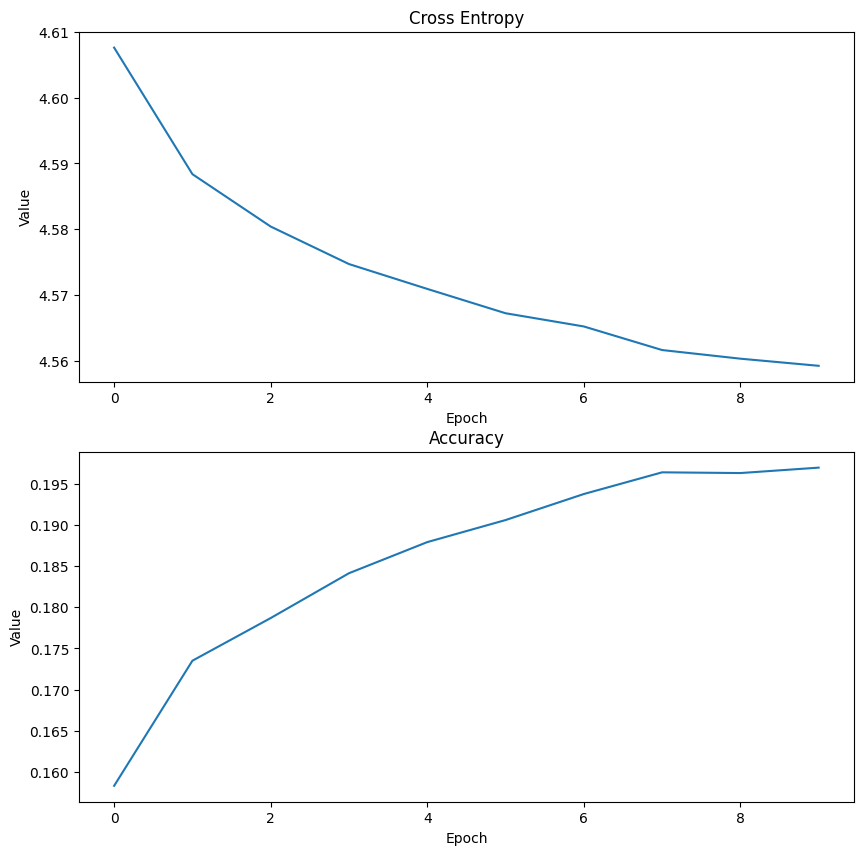

In [41]:
# graph the epoch metrics
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot([m['cross_entropy'] for m in model.epoch_metrics.values()])
ax[0].set_title('Cross Entropy')
ax[1].plot([m['accuracy'] for m in model.epoch_metrics.values()])
ax[1].set_title('Accuracy')
# axes labels
for a in ax:
    a.set_xlabel('Epoch')
    a.set_ylabel('Value')

None


In [ ]:
# Choosing hyperparameters
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-8, 1e-2, log=True)

    model = Model()
    model.learning_rate = learning_rate

    trainer = pl.Trainer(
        max_epochs=10,
        accelerator='cpu',
        default_root_dir="w10checkpoints/",
        accumulate_grad_batches=7
    )

    trainer.fit(model, train_dataloader, val_dataloader)

    val_loss = trainer.callback_metrics["val_loss"].item()
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Optimum hyperparameters: ", study.best_params["learning_rate"])

[I 2024-12-06 02:04:37,732] A new study created in memory with name: no-name-10353569-dfb0-49c0-a7ff-1b75521e4bf9
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 32.1 K | train
---------------------------------------------
32.1 K    Trainable params
0         Non-trainable params
32.1 K    Total params
0.128     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 441.47it/s, v_num=26, val_loss=4.740]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 441.25it/s, v_num=26, val_loss=4.740]


[I 2024-12-06 02:05:01,883] Trial 0 finished with value: 4.7357258796691895 and parameters: {'learning_rate': 2.096940017598267e-06}. Best is trial 0 with value: 4.7357258796691895.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 32.1 K | train
---------------------------------------------
32.1 K    Trainable params
0         Non-trainable params
32.1 K    Total params
0.128     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 445.02it/s, v_num=27, val_loss=4.570]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 444.76it/s, v_num=27, val_loss=4.570]


[I 2024-12-06 02:05:26,092] Trial 1 finished with value: 4.565362453460693 and parameters: {'learning_rate': 0.0022635072835479517}. Best is trial 1 with value: 4.565362453460693.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 32.1 K | train
---------------------------------------------
32.1 K    Trainable params
0         Non-trainable params
32.1 K    Total params
0.128     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 448.18it/s, v_num=28, val_loss=4.740]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 447.93it/s, v_num=28, val_loss=4.740]


[I 2024-12-06 02:05:49,968] Trial 2 finished with value: 4.73578405380249 and parameters: {'learning_rate': 1.8547531574734205e-06}. Best is trial 1 with value: 4.565362453460693.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 32.1 K | train
---------------------------------------------
32.1 K    Trainable params
0         Non-trainable params
32.1 K    Total params
0.128     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 445.01it/s, v_num=29, val_loss=4.640]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 444.73it/s, v_num=29, val_loss=4.640]


[I 2024-12-06 02:06:14,261] Trial 3 finished with value: 4.64071798324585 and parameters: {'learning_rate': 0.00011660549294960126}. Best is trial 1 with value: 4.565362453460693.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 32.1 K | train
---------------------------------------------
32.1 K    Trainable params
0         Non-trainable params
32.1 K    Total params
0.128     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 447.07it/s, v_num=30, val_loss=4.660]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 446.82it/s, v_num=30, val_loss=4.660]


[I 2024-12-06 02:06:38,336] Trial 4 finished with value: 4.657295227050781 and parameters: {'learning_rate': 8.37170392623562e-05}. Best is trial 1 with value: 4.565362453460693.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 32.1 K | train
---------------------------------------------
32.1 K    Trainable params
0         Non-trainable params
32.1 K    Total params
0.128     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 441.37it/s, v_num=31, val_loss=4.730]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 441.11it/s, v_num=31, val_loss=4.730]


[I 2024-12-06 02:07:02,384] Trial 5 finished with value: 4.726443767547607 and parameters: {'learning_rate': 1.0272666769929846e-05}. Best is trial 1 with value: 4.565362453460693.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 32.1 K | train
---------------------------------------------
32.1 K    Trainable params
0         Non-trainable params
32.1 K    Total params
0.128     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 452.14it/s, v_num=32, val_loss=4.610]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 451.90it/s, v_num=32, val_loss=4.610]

[I 2024-12-06 02:07:26,249] Trial 6 finished with value: 4.609470844268799 and parameters: {'learning_rate': 0.00024480235365433663}. Best is trial 1 with value: 4.565362453460693.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 32.1 K | train
---------------------------------------------
32.1 K    Trainable params
0         Non-trainable params
32.1 K    Total params
0.128     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 446.17it/s, v_num=33, val_loss=4.730]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 445.93it/s, v_num=33, val_loss=4.730]


[I 2024-12-06 02:07:50,130] Trial 7 finished with value: 4.733245849609375 and parameters: {'learning_rate': 8.28396786180766e-06}. Best is trial 1 with value: 4.565362453460693.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 32.1 K | train
---------------------------------------------
32.1 K    Trainable params
0         Non-trainable params
32.1 K    Total params
0.128     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 445.76it/s, v_num=34, val_loss=4.570]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 445.49it/s, v_num=34, val_loss=4.570]


[I 2024-12-06 02:08:14,149] Trial 8 finished with value: 4.565550804138184 and parameters: {'learning_rate': 0.0021623516382305113}. Best is trial 1 with value: 4.565362453460693.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 32.1 K | train
---------------------------------------------
32.1 K    Trainable params
0         Non-trainable params
32.1 K    Total params
0.128     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 441.63it/s, v_num=35, val_loss=4.620]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2138/2138 [00:04<00:00, 441.37it/s, v_num=35, val_loss=4.620]


[I 2024-12-06 02:08:38,502] Trial 9 finished with value: 4.620413780212402 and parameters: {'learning_rate': 0.00018963016754246356}. Best is trial 1 with value: 4.565362453460693.


Optimum hyperparameters:  0.0022635072835479517


Text(0.5, 1.0, 'Optuna Study Results')

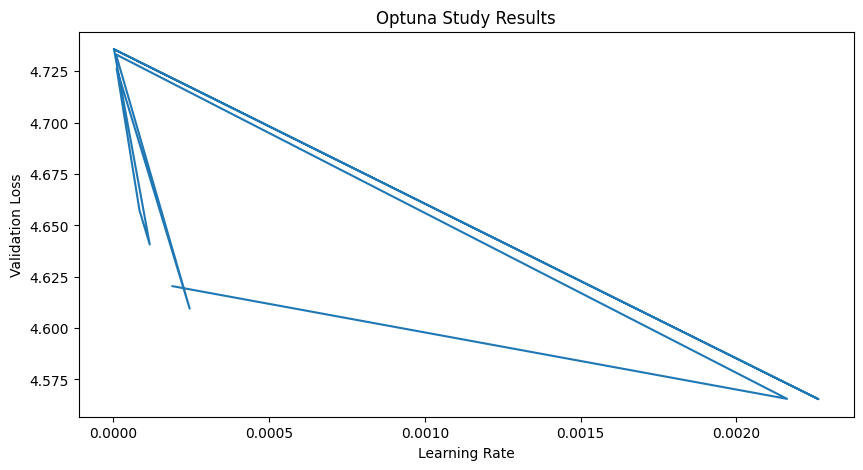

In [62]:
# plot study results by hand with x axis as parameter

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot([t.params['learning_rate'] for t in study.trials], [t.value for t in study.trials])
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_title('Optuna Study Results')
